# Overview of this jupyter notebook

1. Load the data
2. Classification with window technique
3. Evaluating test data with optimized windows
4. Saving results

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
import pickle
import json
import random

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [6]:
import os
import importlib
from library import etl_helper as etl            # this module contains functions that load, visualize and save the data
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(etl))
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.etl_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\etl_helper.py'>
<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>


In [7]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.8.0
Num GPUs Available:  1
Name:  /device:GPU:0


In [8]:
!python -V

Python 3.10.6


# 1. Load and shuffle the data

In [9]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [10]:
feature_train = np.load("feature_label/occ_feature_train_v2.4.npy")
feature_train.shape

(2150, 920)

In [11]:
feature_test = np.load("feature_label/occ_feature_test_v2.4.npy")
feature_test.shape

(750, 920)

In [12]:
label_train = np.load("feature_label/occ_label_train_v2.4.npy")
label_train.shape

(2150, 8)

In [14]:
label_test = np.load("feature_label/occ_label_test_v2.4.npy")
label_test.shape

(750, 8)

In [16]:
# using only curves from class 0 for x_train
# x_test contains 50 curves from each 15 classes

x_train = feature_train[:700]
x_test = feature_test

x_train.shape

(700, 920)

In [17]:
y_train = (np.argmax(label_train, axis=1)>0).astype(int)
y_test = (np.argmax(label_test, axis=1)>0).astype(int)

y_train.shape, (y_test==0).sum()

((2150,), 50)

In [18]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [19]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

# 2. Classification with window technique
## Setting optimal windows with train data to achieve recall 100% for class 0

In [20]:
def classification_with_windows(arr, windows=2,
                                x1min=None, x1max=None, y1min=None, y1max=None, 
                                x2min=None, x2max=None, y2min=None, y2max=None):

    windows = windows
    cl_map = np.zeros(arr.shape[0]*windows).reshape(arr.shape[0], windows).astype(int) 

    for i, curve in enumerate(arr):
        if x1min == None:
            pass
        else:
            if not ((curve[x1min:x1max]>=y1min).all() & (curve[x1min:x1max]<=y1max).all()):
                cl_map[i, 0] = 1
                
        if x2min == None:
            pass
        else:
            if not ((curve.argmax()>x2min) & (curve.argmax()<x2max) & (curve.max()>y2min) & (curve.max()<y2max)):
                cl_map[i, 1] = 1

    return cl_map

In [21]:
def get_confusion_matrix(cl_map, mode="train"):
    
    if mode=="train":      
        threshold=700     # number of curves from class 0 in train data set: 700
    elif mode=="val":      
        threshold=30
    elif mode=="test":
        threshold=50      # number of curves from class 0 in test data set: 50
        
    tp = []
    tn = []
    fp = []
    fn = []

    for i, val in enumerate(cl_map):
        if (i>=threshold) & (val.sum()>0):
            tp.append(i)
        if (i<threshold) & (val.sum()==0):
            tn.append(i)
        if (i<threshold) & (val.sum()>0):
            fp.append(i)
        if (i>=threshold) & (val.sum()==0):
            fn.append(i)
    
    return tp, tn, fp, fn

In [22]:
# setting the first window
# y1max need to be determined 

x1min = 0
x1max = 620     # set range for x axis

y1min = 0

x1min, x1max, y1min

(0, 620, 0)

In [23]:
# convert x1min and x1max in seconds:

print(x1min*0.0035, x1max*0.0035)

0.0 2.17


In [24]:
# setting the height of the first window (y1max) through iteration

start = 0.05
end = 0.1
steps = 0.0005

for i in np.arange(start, end, steps):
    
    x1min = 0
    x1max = 620     # set range for x axis
    y1min = 0
    y1max = i
    
    cl_map_train = classification_with_windows(x_train, windows=2, 
                                           x1min=x1min, x1max=x1max, y1min=y1min, y1max=y1max)
    tp_train, tn_train, fp_train, fn_train = get_confusion_matrix(cl_map_train, mode="train")
  
    if (len(fp_train)==0) & (len(fn_train)==0):
        print(i)

0.09900000000000005
0.09950000000000005


In [25]:
y1max = 0.099

In [26]:
# setting second window: get one reference point from the curves of class 0

xref2 = np.argmax(x_train, axis=1).mean()
print(xref2)

xtol2 = 0.1
x2min = round(xref2 * (1-xtol2))
x2max = round(xref2 * (1+xtol2))
x2min, x2max

668.6271428571429


(602, 735)

In [27]:
# convert x2min and x2max in seconds:

print(xref2*0.0035)
print(x2min*0.0035, x2max*0.0035)

2.340195
2.107 2.5725000000000002


In [28]:
yref2 = 2.4     # fixed target value 

ytol2 = 0.12
y2min = round(yref2 * (1-ytol2), 3)
y2max = round(yref2 * (1+ytol2), 3)
y2min, y2max

(2.112, 2.688)

In [29]:
def plot_windows(curves, x1min=None, x1max=None, y1min=None, y1max=None, 
                 x2min=None, x2max=None, y2min=None, y2max=None, 
                 figsize=(14,7), dpi=100, color="black"):
    
    time = etl.set_time(curves)
    
    plt.figure(figsize=figsize)
    plt.plot(time, curves)
    
    if x1min!=None:
        window1 = plt.Rectangle((time[x1min], y1min), time[x1max-x1min], y1max-y1min, color=color, fill=False, linewidth=2)
        plt.gca().add_patch(window1).set_zorder(10)
    if x2min!=None:
        window2 = plt.Rectangle((time[x2min], y2min), time[x2max-x2min], y2max-y2min, color=color, fill=False, linewidth=2)
        plt.gca().add_patch(window2).set_zorder(10)
   
    plt.rcParams['font.family'] = ['Arial']
    plt.ylabel("Drehmoment in Nm", fontsize=18)
    plt.xlabel("Zeit in Sekunden", fontsize=18)
    plt.scatter(time[int(np.mean([x2min, x2max]))], np.mean([y2min, y2max]), color=color).set_zorder(10)
    plt.tick_params(axis='both', labelsize=16)
    plt.grid()
    plt.show()

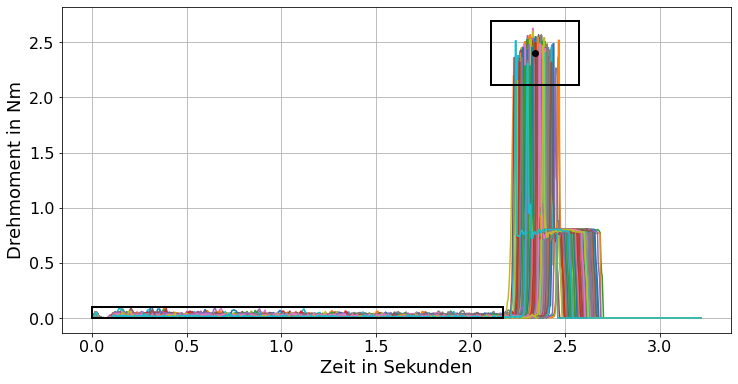

In [30]:
plot_windows(curves=x_train.transpose(), 
             x1min=x1min, x1max=x1max, y1min=y1min, y1max=y1max,
             x2min=x2min, x2max=x2max, y2min=y2min, y2max=y2max,
             figsize=(12,6))

In [31]:
tp_train, tn_train, fp_train, fn_train = get_confusion_matrix(cl_map_train, mode="train")
print(f"tp: {len(tp_train)}, tn: {len(tn_train)}, fp: {len(fp_train)}, fn: {len(fn_train)}")

tp: 0, tn: 700, fp: 0, fn: 0


In [32]:
def prepare_prediction(arr, cl_map, mode="train"):
    
    if mode=="train":      
        threshold=700     # number of curves from class 0 in train data set: 700
    elif mode=="val":      
        threshold=30
    elif mode=="test":
        threshold=50      # number of curves from class 0 in test data set: 50
        
    y_true = np.zeros(arr.shape[0]).astype(int)
    y_true[threshold:] = 1

    y_pred = []

    for i in cl_map:
        if i.sum()==0:
            y_pred.append(0)
        else:
            y_pred.append(1)

    y_pred = np.array(y_pred)
    
    #print(y_true.shape, y_pred.shape)
    return y_true, y_pred

In [33]:
y_true_train, y_pred_train = prepare_prediction(x_train, cl_map_train, mode="train")
print(y_true_train.shape, y_pred_train.shape)

(700,) (700,)


# 3. Evaluating test data with optimized windows

In [34]:
cl_map_test = classification_with_windows(x_test, windows=2,
                                           x1min=x1min, x1max=x1max, y1min=y1min, y1max=y1max,
                                           x2min=x2min, x2max=x2max, y2min=y2min, y2max=y2max)

cl_map_test

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [1, 1],
       [1, 1],
       [1, 1]])

In [35]:
tp_test, tn_test, fp_test, fn_test = get_confusion_matrix(cl_map_test, mode="test")
print(f"tp: {len(tp_test)}, tn: {len(tn_test)}, fp: {len(fp_test)}, fn: {len(fn_test)}")

tp: 691, tn: 50, fp: 0, fn: 9


In [36]:
y_true_test, y_pred_test = prepare_prediction(x_test, cl_map_test, mode="test")
y_true_test.shape, y_pred_test.shape

((750,), (750,))

In [37]:
def get_results(y_true, y_pred):
    
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return acc, rec, pre, f1

In [38]:
acc_test, rec_test, pre_test, f1_test = get_results(y_true_test, y_pred_test)
print(f"test results\n"
      f"acc: {acc_test}\n"
      f"rec: {rec_test}\n"
      f"pre: {pre_test}\n"
      f"f1:  {f1_test}")

test results
acc: 0.988
rec: 0.9871428571428571
pre: 1.0
f1:  0.9935298346513299


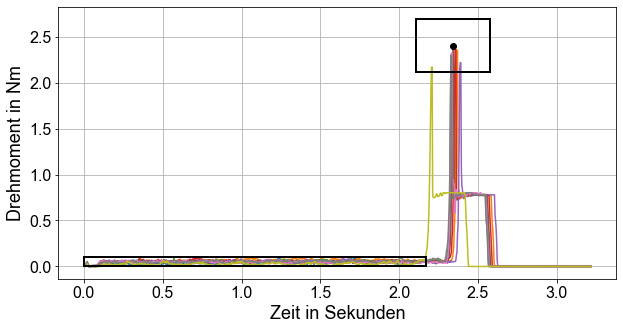

In [39]:
plot_windows(curves=x_test[fn_test].transpose(), 
             x1min=x1min, x1max=x1max, y1min=y1min, y1max=y1max,
             x2min=x2min, x2max=x2max, y2min=y2min, y2max=y2max,
             figsize=(10,5))

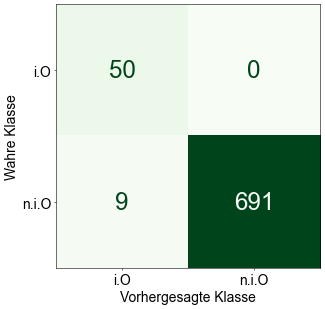

In [41]:
ch.plot_calc_cm(y_true_test, y_pred_test, class_name=["i.O", "n.i.O"], dpi=50)

In [42]:
fn_test

[254, 255, 262, 263, 270, 291, 296, 299, 568]

In [43]:
for i, val in enumerate(cl_map_test):
    if (i>=50) & (val.sum()==0):
        print(i, val)

254 [0 0]
255 [0 0]
262 [0 0]
263 [0 0]
270 [0 0]
291 [0 0]
296 [0 0]
299 [0 0]
568 [0 0]


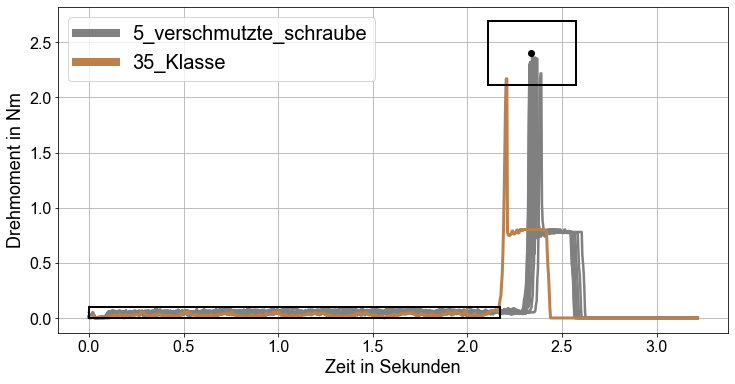

In [44]:
time = etl.set_time(x_test[-1])
    
plt.figure(figsize=(12,6))
plt.plot(time, x_test[fn_test[:8]].transpose(), fapsc.grey_0, linewidth=2.5)
plt.plot([], [], fapsc.grey_0, label='5_verschmutzte_schraube')
plt.plot(time, x_test[fn_test[-1]].transpose(), '#ba814f', linewidth=3, label='35_Klasse')

if x1min!=None:
    window1 = plt.Rectangle((time[x1min], y1min), time[x1max-x1min], y1max-y1min, color=fapsc.black, fill=False, linewidth=2)
    plt.gca().add_patch(window1).set_zorder(10)
if x2min!=None:
    window2 = plt.Rectangle((time[x2min], y2min), time[x2max-x2min], y2max-y2min, color=fapsc.black, fill=False, linewidth=2)
    plt.gca().add_patch(window2).set_zorder(10)

plt.rcParams['font.family'] = ['Arial']
plt.ylabel("Drehmoment in Nm", fontsize=18)
plt.xlabel("Zeit in Sekunden", fontsize=18)
plt.scatter(time[int(np.mean([x2min, x2max]))], np.mean([y2min, y2max]), color=fapsc.black).set_zorder(10)
plt.tick_params(axis='both', labelsize=16)
leg = plt.legend(loc='upper left', fontsize=20)
for line in leg.get_lines():
    line.set_linewidth(8)
plt.grid()
plt.show()

# 4. Saving results

In [104]:
res = ch.collect_results_occ(y_true_test, y_pred_test, algorithm="fenstertechnik", params=None, 
                          best_param=None, cm=confusion_matrix(y_true_test, y_pred_test).tolist())
res

{'algorithm': 'fenstertechnik',
 'params': None,
 'best_param': None,
 'cm': [[50, 0], [9, 691]],
 'rec': 0.9871428571428571,
 'pre': 1.0,
 'f1': 0.9935298346513299,
 'acc': 0.988}

In [105]:
#ch.save_results_json(filename="occ_hyperopt_results_v2.4.1.json", 
                     key_algorithm = "fenster", 
                     hyperopt_result = res)

existing file occ_hyperopt_results_v2.4.1.json opened and results of fenster saved.
